#Statistical Analysis of Financial Data - Project Part 2: **Extremely Randomized Forests**
# Kushagra Mahajan (170123029)<br> Mihir Yadav (170123034)
###Group 3
#Disclaimer
*The content of this report and the product made is only meant for learning process as part of the course. This is not for use of making publication or making commercialisation without mentor’s consent. My contribution won’t demand any claim in future for further progress of Mentor’s development and innovation along the direction unless there is a special continuous involvement.*



#Extremely Randomized/Extra Trees Algorithm
As part of the project 1 we worked on constructing a decision tree algorithm and then created classical random forests, by introducing variation in the decision trees.

We used bootstrapping and and the generic technique of random-subspace projection, which is choosing a random subset of attributes for each tree, to build random decision trees for a forest.

Although these significantly randomized the standard tree growing algorithm, they are far from building totally random trees. The very high variance of decision/regression tree splits motivated the use of even higher randomization levels, that could give better performance, both in terms of accuracy and computational efficiency.  

For this purpose we look at another tree-ensemble technique which aims at strongly randomizing the individual decision trees. The strength of this randomization can be controlled by the use of a parameter. In extreme cases, totally random trees can be built, with structures independent of the output values of the training samples.

##Algorithm description
The Extra-trees algorithm builds an ensemble of unpruned decision trees with increased randomization with respect to the trees constructed as part of Project 1. The classical top-down approach is used for construction.

To increase the randomization level, at each tree node, a random subset of features is chosen to be split on, and further the cut-point for each split is chosen at random. The split that gives maximum variance reduction at the node is chosen. In the extreme case only one feature is chosen at random and the samples are split at a random cut-point for this feature. This way *Totally Randomized Tress* are built, without taking the target variable of the training samples into account. We introduce a parameter *subset_size_factor* that can control the extent of randomization in trees.

This algorithm differs from the previous implementation also with respect to the treatment of training samples. The whole training data available is used instead of a bootstrap replica as in the previous implementation.


---
---
####**Extra-trees splitting algorithm for numerical attributes**
---
**Split node** (S):<br>
  *Input:* The training subset at a tree node with attributes [$a_{1}, a_{2}, a_{3}\cdots, a_{n}$].<br>
  *Output:* A split at this node in the form of *(feature, cut-point)*<br>



*   $k$ = subset_size_factor*$n$
<br>
*   Randomly select $k$ features $[a_{p_{1}},a_{p_{2}}, a_{p_{3}}\cdots,a_{p_{k}}]$
<br>
*   Randomly select cut-points $s_{p_{i}}$ for each feature $a_{p_{i}}$ as $s_{p_{i}} = random(minS(a_{p_{i}}), maxS(a_{p_{i}}))$ 
<br>
*   Select the split feature and cut-point as $(a_{p}, s_{p})$ which gives the maximum variance reduction, that is $VarReduction(S, a_{p}, s_{p}) = \displaystyle\max_{i=1}^{k}{VarReduction(S, a_{p_{i}}, s_{p_{i}})}$


---
---
<br>
The tree is built and nodes split until some stopping criterion is met. For this project we use the $\mathrm{coefficient\ of\ variance}$: 
<br>
$\mathrm{CoefVar} = \dfrac{\mathrm{Standard\ Deviation}}{\mathrm{Mean}} = \dfrac{\sqrt{\dfrac{1}{n}\sum_{j}(y_{j}-\bar y)^{2}}}{\bar y}$

which is a measure of the variability of data relative to the mean.

At every node we calculate this coefficient and if it falls below a certain threshold, $i.e.$ the variability of data has reduced enough, the node is not split any more.



In [ ]:
import numpy as np
import sklearn.metrics as metrics

class TreeNode:
    def __init__(self):
        self.predicted_value = None
        self.decision_feature = None
        self.decision_value = None
        self.left_node = None
        self.right_node = None


class DecisionTree:

    def __init__(self):
        self.root_node = None
        self.min_coef_of_var = None
        self.subset_size_factor = None
        self.reductions = None

    def fit(self, X, Y, min_coef_of_var = 0, pruning_factor = 0, subset_size_factor = 1/np.sqrt(len(X_train[0])), extremely_randomized=False):
        self.min_coef_of_var = min_coef_of_var
        self.subset_size_factor = subset_size_factor
        self.extremely_randomized = extremely_randomized  #Prameter that controls whether to create extremely randomized trees.
        self.root_node = self.build(X, Y)
        self.prune_decision_tree(X, Y, self.root_node, pruning_factor)

        self.reductions = np.zeros(len(X[0]))
        self.reductions = self.calculate_reductions(X, Y, self.root_node, self.reductions)

    def get_decision_value_for_feature(self, X, Y, decision_feature):
        
        Z = np.empty((0, 2), float)
        for i in range(len(Y)):
            Z = np.append(Z, [[X[i, decision_feature], Y[i]]], axis = 0)

        Z = np.sort(Z, axis = 0)

        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0
        left_sum_of_squares = 0
        right_sum_of_squares = 0

        for i in range(len(Z)):
            right_cardinality += 1
            right_sum += Z[i, 1]
            right_sum_of_squares += Z[i, 1] ** 2

        current_best_impurity = right_sum_of_squares
        current_best_decision_value = Z[0, 0] - 1

        for i in range(len(Z)):
            left_cardinality += 1
            left_sum += Z[i, 1]
            left_sum_of_squares += Z[i, 1] ** 2

            right_cardinality -= 1
            right_sum -= Z[i, 1]
            right_sum_of_squares -= Z[i, 1] ** 2

            impurity = left_sum_of_squares - left_sum * left_sum / left_cardinality
            if (right_cardinality != 0):
                impurity += right_sum_of_squares - right_sum * right_sum / right_cardinality
            
            if (impurity < current_best_impurity):
                current_best_impurity = impurity
                current_best_decision_value = Z[i, 0]

        return current_best_decision_value

    def get_impurity(self, X, Y, decision_feature, decision_value_for_feature):
        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0

        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                left_cardinality += 1
                left_sum += Y[i]
            else:
                right_cardinality += 1
                right_sum += Y[i]

        if (left_cardinality != 0):
            left_mean = left_sum / left_cardinality
        else:
            left_mean = 0

        if (right_cardinality != 0):
            right_mean = right_sum / right_cardinality
        else:
            right_mean = 0

        impurity = 0
        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                impurity += (Y[i] - left_mean) ** 2
            else:
                impurity += (Y[i] - right_mean) ** 2

        return impurity

    def divide_data(self, X, Y, decision_feature, decision_value):
        number_of_features = len(X[0])
        X_left = np.empty((0, number_of_features), float)
        X_right = np.empty((0, number_of_features), float)
        Y_left = np.empty(0, float)
        Y_right = np.empty(0, float)

        for i in range(len(X)):
            if (X[i, decision_feature] <= decision_value):
                X_left = np.append(X_left, [X[i]], axis = 0)
                Y_left = np.append(Y_left, [Y[i]], axis = 0)
            else:
                X_right = np.append(X_right, [X[i]], axis = 0)
                Y_right = np.append(Y_right, [Y[i]], axis = 0)

        return X_left, Y_left, X_right, Y_right

    def build(self, X, Y):
        if (len(X) == 0):
            return

        root_node = TreeNode()
        node_mean = np.mean(Y)
        root_node.predicted_value = node_mean
        node_deviation = np.std(Y)

        # Do not split
        if (node_deviation / node_mean < self.min_coef_of_var):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return

        if (np.amin(Y) == np.amax(Y)):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return root_node

        
        current_best_feature = -1
        current_best_decision_value = -1
        current_best_impurity = -1
        number_of_features = len(X[0])
        if self.extremely_randomized == True:
          features_subset = random.sample(range(number_of_features),int(number_of_features*self.subset_size_factor))
        else:
          features_subset = range(number_of_features)
        ## iterate only on a subset of features and choose the best among them
        for i in features_subset:
            if self.extremely_randomized == False:
              decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            else:
              decision_value_for_feature = random.sample(list(X[:, i]),1) ## pick a random cut point
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            if (current_best_feature == -1 or impurity_of_decision_value < current_best_impurity):
                current_best_feature = i
                current_best_decision_value = decision_value_for_feature
                current_best_impurity = impurity_of_decision_value

        root_node.decision_feature = current_best_feature
        root_node.decision_value = current_best_decision_value

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)

        if (len(Y_left) == 0 or len(Y_right) == 0):
            return root_node
        root_node.left_node = self.build(X_left, Y_left)
        root_node.right_node = self.build(X_right, Y_right)
        return root_node

    def prune_decision_tree(self, X, Y, root_node, pruning_factor):
        if (root_node == None):
          return 0

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        left_tree_size = self.prune_decision_tree(X_left, Y_left, root_node.left_node, pruning_factor)
        right_tree_size = self.prune_decision_tree(X_right, Y_right, root_node.right_node, pruning_factor)
        tree_size = 1 + left_tree_size + right_tree_size

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        divided_impurity = self.get_impurity(X, Y, root_node.decision_feature, root_node.decision_value)

        pruning_value = impurity / len(Y) - divided_impurity / len(Y) - pruning_factor * tree_size

        if (pruning_value < 0):
            root_node.left_node = None
            root_node.right_node = None
            return 1
        else:
            return tree_size
    
    def calculate_reductions(self, X, Y, root_node, reductions):
        if (root_node == None):
            return reductions

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        for i in range(len(X[0])):
            decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            reductions[i] += impurity - impurity_of_decision_value
        
        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        reductions = self.calculate_reductions(X_left, Y_left, root_node.left_node, reductions)
        reductions = self.calculate_reductions(X_right, Y_right, root_node.right_node, reductions)

        return reductions
    
    def get_reductions(self):
        return self.reductions

    def predict_single(self, X):
        current_node = self.root_node
        while (True):
            if (X[current_node.decision_feature] <= current_node.decision_value):
                if (current_node.left_node != None):
                    current_node = current_node.left_node
                else:
                    return current_node.predicted_value
            else:
                if (current_node.right_node != None):
                    current_node = current_node.right_node
                else:
                    return current_node.predicted_value

    def predict(self, X):
        Y = np.empty(0, float)
        for x in X:
            Y = np.append(Y, [self.predict_single(x)], axis = 0)

        return Y

decision_tree = DecisionTree()

We will use Boston housing data from ```sklearn.datasets``` for testing our algorithm.



In [ ]:
from sklearn.datasets import load_boston
data = load_boston(return_X_y=False)
X = data.data
y = data.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

We fit our decision tree to the training data, and check our performance on the test data.

**Note:** Using a single Extra-tree does not make sense because the tree structure is based on random splits, hence we need to make an **ensemble of multiple Extra-trees** as shown later

In [ ]:
import random
decision_tree.fit(X_train, y_train, min_coef_of_var = 0.025, pruning_factor = 0, extremely_randomized=True)
y_test_pred = decision_tree.predict(X_test)
metrics.r2_score(y_test, y_test_pred)

0.5389992736916642

For a single tree with randomized splits, as expected the fit is not good

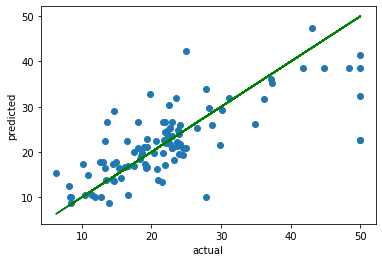

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_test_pred)
plt.show()

#Forest of Extremely randomized trees
We now implement an extremely randomized forest as an ensemble of Extra-trees. The rationale behind this approach is that the increased explicit randomization of the attributes and cut-points, when combined with ensemble averaging should be able to reduce variance more strongly than the previously implemented weaker randomization technique. The **results from each extra-tree is averaged** to give the final result.

We avoid using bootstrap replicas and intsead go for the full original training sample to minimize the bias. Computationally this implementation is much more efficient than the previous as we no longer need to iterate over all features and explicitly calculate the cut-split value for them.

In [ ]:
from numpy.random import choice, seed

class RandomForest:

    trees = []
    importance = None

    def __init__(self):
        self.trees = []

    def fit(self, X, y, num_trees = 1, frac_samples = None, frac_attrs = None, bootstrap=False, extremely_randomized=False, subset_size_factor=1/np.sqrt(len(X_train[0]))):
        seed(0)
        if extremely_randomized and bootstrap:
          print('----------------Extremely randomized tress run without bootstrap------------------')
          bootstrap = False
        N, total_attributes = X.shape 
        self.importance = np.zeros(total_attributes)

        if frac_samples == None:
            frac_samples = 1.0

        if frac_attrs == None:
            frac_attrs = 1.0

        for i in range(num_trees):
            new_tree = DecisionTree()
            sample = choice(range(N), size = int(N * frac_samples), replace=bootstrap)
            attrs = choice(range(total_attributes), size = int(total_attributes * frac_attrs), replace=bootstrap)
            #print(attrs, end=", ")
            dataset = X[sample, :]   #[:, attrs]
            ys = y[sample]
            new_tree.fit(dataset, ys, min_coef_of_var = 0.025, pruning_factor = 0, extremely_randomized=extremely_randomized, subset_size_factor=subset_size_factor)

            self.importance += new_tree.get_reductions()

            self.trees.append((new_tree, attrs))

        self.importance /= num_trees

    def predict(self, X):
        
        N, _ = X.shape 

        answer = np.zeros(N)

        for (t, attrs) in self.trees:
            answer += t.predict(X) # [:, attrs])
        
        return answer / len(self.trees)

In [ ]:
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 1.0, bootstrap=False, extremely_randomized=True, subset_size_factor=0.7)

And then we test it on our test-data.

In [ ]:
y_test_rf = rf.predict(X_test)
y_test_rf
metrics.r2_score(y_test, y_test_rf)

0.8792682371177334

We also calculate the results using sklearn's RandomForestRegressor for comparison

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfsk = RandomForestRegressor(bootstrap=True)
rfsk.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_test_rfsk = rfsk.predict(X_test)
metrics.r2_score(y_test, y_test_rfsk)

0.905033102965088

We see that scikit-learn manages an accuracy of ~90%. Our ~88% is quite comparable, given that our implementation is very bare-bones, and mostly proof-of-concept.

Finally, we plot our predictions as opposed to the ground truth (x = y). 

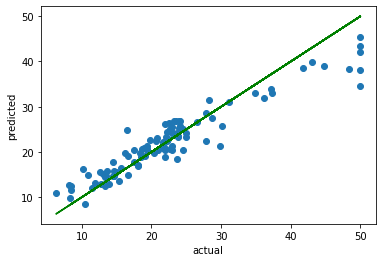

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_test_rf)
plt.show()

We see that a large chunk of the predicted points is really close to the ground truths. This is because of the averaging step in the Random Forests, and contributes immensely to the accuracy.

## Variable Importance

Now we take a look at the importance of variables. For this purpose, we compute the following quantity for each tree $T$ in the ensemble:

$\mathrm{VarReduction}_i = \sum_{x \in T} \mathrm{Optimal\ Variance\ Reduction\ in\ node\ } x \mathrm{\ by\ attribute\ } i$

and then denote 

$\mathrm{Importance}_i = \mathrm{Average\ of\ VarReduction}_i$

This quantity will be the importance of attribute $i$. We plot these quantities in a relative sense.


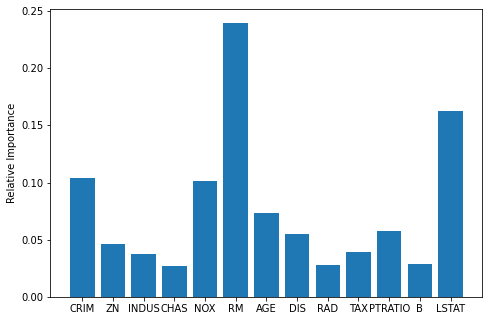

In [ ]:
importance = rf.importance
relative_importance = importance / np.sum(importance)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(data.feature_names, relative_importance)
plt.ylabel('Relative Importance')
plt.show()

The following are the meanings of the attributes:

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per $10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000's


So we can see that the most important attribute is RM, which is the average number of rooms. This makes sense, because the number of rooms is an important factor. The 2nd most important factor is LSTAT, which is the percentage of the population which is of lower status. This can be interpreted to mean that the price is lower in underdeveloped regions. And the 3rd most important factor is crime rate (CRIM), which too makes a lot of sense. On the other end, the CHAS variable is about the Charles River. It doesn't make too much of an impact on the price.

#Results comparison with alternative approaches
Finally we run different instances of our model wit slightly differences to compare the performance.

In [ ]:
import time

##Implementation in Project 1: Without extra-trees
We use the bootstrapping technique while training to generate randomized trees

In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 1.0, bootstrap=True, extremely_randomized=False, subset_size_factor=0.45)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8576024032476958
Time taken to run:  145.09849524497986


We use the implementation in project 1 with bootstrapping combined with taking a fraction of features to grow more randomized individual tree.

In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 0.7, bootstrap=True, extremely_randomized=False, subset_size_factor=0.45)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8656771069680278
Time taken to run:  138.87495183944702


In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 50, frac_samples = 1, frac_attrs = 0.7, bootstrap=True, extremely_randomized=False, subset_size_factor=0.45)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8710594342964576
Time taken to run:  71.20021986961365


##New implementation: Using Extremely randomized/Extra trees
We run the model multiple times with different set parameters.

In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 1.0, bootstrap=False, extremely_randomized=True, subset_size_factor=0.45)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.867215782842968
Time taken to run:  109.24748802185059


In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 1.0, bootstrap=False, extremely_randomized=True, subset_size_factor=0.3)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8344705204000646
Time taken to run:  100.29421710968018


In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 100, frac_samples = 1, frac_attrs = 1.0, bootstrap=False, extremely_randomized=True, subset_size_factor=0.7)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8844838534245865
Time taken to run:  118.73557686805725


In [ ]:
start_time = time.time()
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 50, frac_samples = 1, frac_attrs = 1.0, bootstrap=False, extremely_randomized=True, subset_size_factor=0.7)
y_test_rf = rf.predict(X_test)
y_test_rf
print('R2 Score: ', metrics.r2_score(y_test, y_test_rf))
print('Time taken to run: ', time.time()-start_time)

R2 Score:  0.8897696687443407
Time taken to run:  60.10095024108887


#Conclusion
We make the following observations from above experiments:


*   Using extremely-randomized trees gives an **increase of about $2\%$** as compared to the classical radom forests. 
*   The Extremely randomized approach is **computationally much more efficient**.
*   We observe that there is a significant difference in the computational efficiency even for the small dataset that we have used. For a dataset with larger number of training samples and attribute space this difference will increase further. 
*   The ensemble method performance is optimized even with upto just 50 trees.

*   Our Extremely randomized model with the parameters achived a $R2score$ of $~89\%$ which comes very close to the $90\%$ score optimized random forest implementation of *sci-kit learn*.

#References:


*   https://towardsdatascience.com/an-intuitive-explanation-of-random-forest-and-extra-trees-classifiers-8507ac21d54b
*   Extremely randomized trees: https://link.springer.com/article/10.1007/s10994-006-6226-1







